In [1]:
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [2]:
def get_features(img):
    ####### using the SIFT function to compute the key points
    sift = cv2.SIFT_create()
    kp = sift.detect(img,None)
    kp , des = sift.compute(img , kp)
    return kp , des

def match_keypoints(des1 , des2) :
    ######## matching the key points
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    
    ####### performing ratio testing
    good = []
    for m,n in matches:
        ####### comparing the distances
        if m.distance < 0.95*n.distance:
            good.append([m])            
    return good

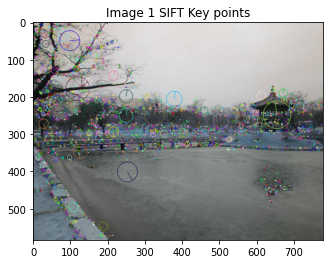

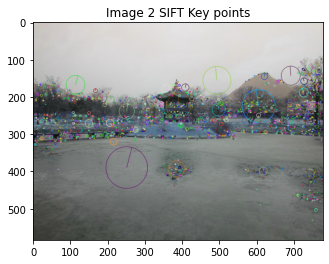

In [3]:
####### loading the images
img1 = cv2.imread('img1.jpg')
img2 = cv2.imread('img2.jpg')

####### computing the key points and descriptors
kp1 , des1 = get_features(img1)
kp2 , des2 = get_features(img2)

########### plotting the keypoints
img1_kp_plot =cv2.drawKeypoints(img1.copy(),kp1,img1.copy(),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img1_kp_plot)
plt.title('Image 1 SIFT Key points')
plt.show()

img2_kp_plot =cv2.drawKeypoints(img2.copy(),kp2,img2.copy(),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img2_kp_plot)
plt.title('Image 2 SIFT Key points')
plt.show()

cv2.imwrite('task1_sift_image1.png' , img1_kp_plot)
cv2.imwrite('task1_sift_image2.png' , img2_kp_plot)

########## computing the key point matches
good = match_keypoints(des1 , des2)

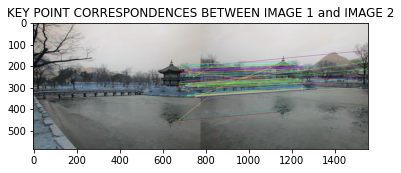

True

In [4]:
####### plotting the key point matches
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good[-100:],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.title('KEY POINT CORRESPONDENCES BETWEEN IMAGE 1 and IMAGE 2')
plt.show()
cv2.imwrite('task1_corresponding.png',img3)

In [5]:
def find_homography(img1_pts , img2_pts):
    ######## declaring the A matrix
    matrix_A = np.zeros((int(2*len(img1_pts)),9))
    
    for i in range(len(img1_pts)) :
        ####### Equation 1 for a pair of matched points
        matrix_A[2*i][0] = -img1_pts[i][0]
        matrix_A[2*i][1] = -img1_pts[i][1]
        matrix_A[2*i][2] = -1
        matrix_A[2*i][6] = img1_pts[i][0]*img2_pts[i][0]
        matrix_A[2*i][7] = img1_pts[i][1]*img2_pts[i][0]        
        matrix_A[2*i][8] = img2_pts[i][0]    
        
        ######### Equation 2 for a pair of matched points
        matrix_A[2*i+1][3] = -img1_pts[i][0]
        matrix_A[2*i+1][4] = -img1_pts[i][1]
        matrix_A[2*i+1][5] = -1
        matrix_A[2*i+1][6] = img1_pts[i][0]*img2_pts[i][1]
        matrix_A[2*i+1][7] = img1_pts[i][1]*img2_pts[i][1]        
        matrix_A[2*i+1][8] = img2_pts[i][1]
    
    ######## computing the SVD
    u,s,v = np.linalg.svd(matrix_A)
    ######## taking the last column of the V.T matrix
    H_matrix_svd = v[-1,:].reshape(3,3)
    return H_matrix_svd

In [6]:
######## Creating the matching point arrays to run the homography mstrix computation
good_img1 , good_img2 = [], []
for i in range(len(good)) :
    good_img1.append(np.flip(kp1[good[i][0].queryIdx].pt))
    good_img2.append(np.flip(kp2[good[i][0].trainIdx].pt))    

###### comptuting the homography matrix
H_svd = find_homography(good_img1 , good_img2)

In [7]:
print('The Homography matrix H is :')
print(H_svd)

The Homography matrix H is :
[[-1.36188238e-03 -3.21642529e-04  5.08913096e-01]
 [-2.34705344e-03 -4.77032014e-04  8.60811869e-01]
 [-4.42479267e-06 -1.00380011e-06  1.64088891e-03]]


In [8]:
######### RANSAC ALGORITHM #############

def transform_ransac(img1_pts , img2_pts) :
    
    H_optimal = np.zeros((3,3))
    num_inliers = 0
    inliers = []
    
    ###### looping for a given number of times
    for i in range(400) :
        
        ######## random sampling 4 points
        randomlist  = random.sample(range(0,img1_pts.shape[0]-1),4)
    
        list_img1_pts , list_img2_pts = [] , []
    
        [ list_img1_pts.append(img1_pts[i,:]) for  i in randomlist ]
        [ list_img2_pts.append(img2_pts[i,:]) for  i in randomlist ]
        
        ######### finding the homography for the 4 points
        H_svd = find_homography(list_img1_pts , list_img2_pts )
        
        ######### computing the homogeneous coordinates for the points
        homogeneous_img1_pts = np.concatenate( [ img1_pts , np.ones((img1_pts.shape[0],1)) ] , axis = 1 )
        homogeneous_img2_pts = np.concatenate( [ img2_pts , np.ones((img2_pts.shape[0],1)) ] , axis = 1 )
        ######### computing the transformed coordinates using P' = H.P
        transformed_img1_pts = np.dot(H_svd , homogeneous_img1_pts.T).T
        transformed_img1_pts = transformed_img1_pts / transformed_img1_pts[:,2].reshape(-1,1)
        
        ########## computing the distance measure
        distance_measure =  np.sum( ( homogeneous_img2_pts - transformed_img1_pts )**2 , axis = 1 )
        ######### declaring as inlier if the distance metric is less than 3 pixels away
        inliers_index = distance_measure < 18
        ########## computing number of inliers
        new_num_inliers = np.sum(inliers_index)
        
        ########## updating the H matrix and number of inliers
        if num_inliers < new_num_inliers : 
            num_inliers = new_num_inliers
            inliers = inliers_index
            H_optimal = H_svd
    
    ########## computing the H matrix again with all the inliers
    list_img1_pts , list_img2_pts = [] , []
    for i in range(len(inliers)) :
        if inliers[i] == True :
            list_img1_pts.append(img1_pts[i,:])
            list_img2_pts.append(img2_pts[i,:])
                
    H_optimal = find_homography(list_img1_pts , list_img2_pts )
            
    return H_optimal , num_inliers , inliers

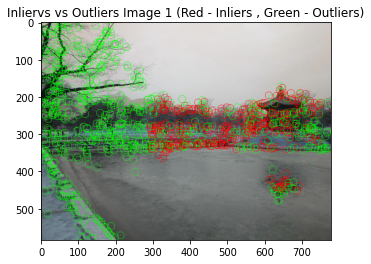

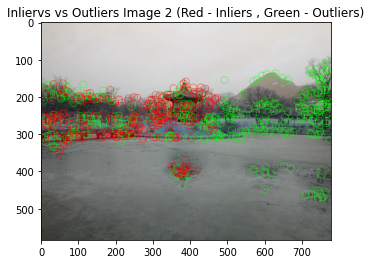

True

In [9]:
########## RANSAC ALGORITHM SNIPPET
array_img1_pts = np.array(good_img1)
array_img2_pts = np.array(good_img2)
H_ransac_optimal , num_inliers , inliers = transform_ransac(array_img1_pts , array_img2_pts)

image = img1.copy()
for i in range(len(good_img1)) :
    if inliers[i] == True :
        center = (int(good_img1[i][1]) , int(good_img1[i][0]) )
        image = cv2.circle(image, center, 10, (255,0,0), 1)
    else :
        center = (int(good_img1[i][1]) , int(good_img1[i][0]) )
        image = cv2.circle(image, center, 10, (0,255,0), 1)
plt.imshow(image)
plt.title('Inliervs vs Outliers Image 1 (Red - Inliers , Green - Outliers)')
plt.show()
cv2.imwrite('Image1inliers.png' , image)

image = img2.copy()
for i in range(len(good_img2)) :
    if inliers[i] == True :
        center = (int(good_img2[i][1]) , int(good_img2[i][0]) )
        image = cv2.circle(image, center, 10, (255,0,0), 1)
    else :
        center = (int(good_img2[i][1]) , int(good_img2[i][0]) )
        image = cv2.circle(image, center, 10, (0,255,0), 1)
plt.imshow(image)
plt.title('Inliervs vs Outliers Image 2 (Red - Inliers , Green - Outliers)')
plt.show()
cv2.imwrite('Image2Inliers.png' , image)

In [10]:
print('Homography matrix from RANSAC algorithm')
print(H_ransac_optimal)

Homography matrix from RANSAC algorithm
[[ 2.84001853e-03  4.98416014e-04 -3.48094986e-01]
 [-6.96873693e-06  3.25003928e-03 -9.37447564e-01]
 [ 2.46413045e-07  1.83903382e-06  1.75165645e-03]]


In [11]:
########## PANAROMIC STITCHING ################

def panaromic_stitching(img1 , img2 , H) :
    img1 = img1/255
    img2 = img2/255
    H_inverse = np.linalg.inv(H)  
    ######### declaring the combined image
    combined_image = np.zeros(( img1.shape[0] ,img1.shape[1]+img2.shape[1] , 3))
    ######### looping over the entire combined image
    for i in range(combined_image.shape[0]) :
        for j in range(combined_image.shape[1]) :
            ######## inverse mapping code
            pt = np.array([i,j,1])
            img_pt = np.dot(H , pt)
            img_pt = img_pt/img_pt[2]     
            img_pt = img_pt[:2]
            ######## checking if the inverse mapped point is within the bounds of the actual image
            if img_pt[0] < img2.shape[0] and img_pt[0] > 0 and img_pt[1] < img2.shape[1] and img_pt[1] > 0 :
                ######## If yes, then we are equating the intensities of the corresponding pixels
                combined_image[i,j,:] = img2[int(img_pt[0]) , int(img_pt[1]) , :]
    
    combined_image[:,:img1.shape[1],:] = img1  
    plt.imshow(combined_image)  
    cv2.imwrite('2image_panaroma.png',255*combined_image)
    
    return combined_image

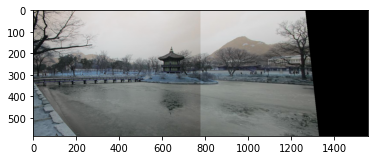

In [12]:
combined_image = panaromic_stitching(img1 , img2 , H_ransac_optimal)

In [13]:
########## PANAROMIC STITCHING MULTIPLE ################

def panaromic_stitching_multiple(img1 , img2 , img3 , H_12 , H_32) :
    img1 = img1/255
    img2 = img2/255
    img3 = img3/255
    ########## declaring the combined image
    combined_image = np.zeros(( img1.shape[0] ,img1.shape[1]+img2.shape[1]+img3.shape[1] , 3))
    
    ########## looping over for image 1 
    for i in range(0,img1.shape[0]) :
        for j in range(-img1.shape[1] , img1.shape[1]) :
            
            pt = np.array([i,j,1])
            img_pt = np.dot(H_12 , pt)
            img_pt = img_pt/img_pt[2]     
            img_pt = img_pt[:2]

            if img_pt[0] < img1.shape[0] and img_pt[0] > 0 and img_pt[1] > 0 and img_pt[1] < img1.shape[1]:
                combined_image[i,j+img1.shape[1],:] = img1[int(img_pt[0]) , int(img_pt[1]) , :]
    
    ########## looping over for image 3
    for  i in range(img3.shape[0]) :
         for j in range(img1.shape[1],combined_image.shape[1]) :
            
            pt = np.array([i,j-img1.shape[1],1])
            img_pt = np.dot(H_32 , pt)
            img_pt = img_pt/img_pt[2]     
            img_pt = img_pt[:2]
            
            if img_pt[0] < img3.shape[0] and img_pt[0] > 0 and img_pt[1] < img3.shape[1] and img_pt[1] > 0 :
                combined_image[i,j,:] = img3[int(img_pt[0]) , int(img_pt[1]) , :]
    
    combined_image[:,img1.shape[1]:img1.shape[1]+img2.shape[1],:] = img2  
    plt.imshow(combined_image)    
    cv2.imwrite('output.png',255*combined_image) 
    
    return combined_image

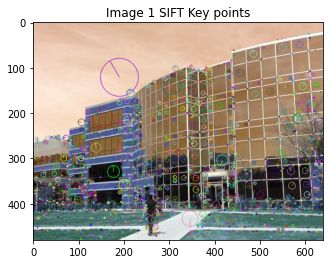

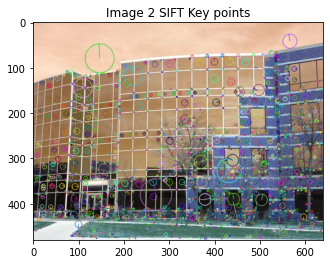

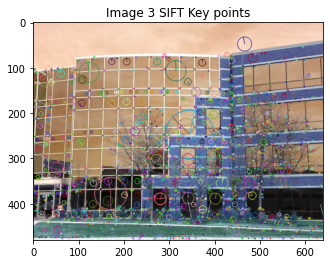

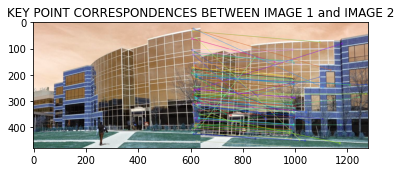

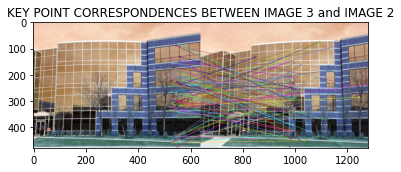

Homography Matrix for Image 1 , Image 2
[[ 3.73734992e-03 -6.16984298e-04  3.26802567e-02]
 [ 2.97693306e-04  3.06510143e-03  9.99446001e-01]
 [ 8.26869911e-08 -1.51426054e-06  3.98251286e-03]]
Homography Matrix for Image 3 , Image 2
[[ 9.17396617e-03  4.94698110e-04 -1.97818729e-01]
 [-1.48081830e-04  9.52834711e-03 -9.80110908e-01]
 [ 1.56318280e-08  1.36630445e-06  8.66839426e-03]]


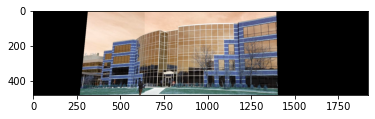

In [14]:
############### PANAROMA FOR 3 images ###############

image1 = cv2.imread('image1.jpg')
image2 = cv2.imread('image2.jpg')
image3 = cv2.imread('image3.jpg')

######## computing the features and descriptors of points
kp1 , des1 = get_features(image1)
kp2 , des2 = get_features(image2)
kp3 , des3 = get_features(image3)

img1_kp_plot =cv2.drawKeypoints(image1.copy(),kp1,image1.copy(),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img1_kp_plot)
plt.title('Image 1 SIFT Key points')
plt.show()

img2_kp_plot =cv2.drawKeypoints(image2.copy(),kp2,image2.copy(),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img2_kp_plot)
plt.title('Image 2 SIFT Key points')
plt.show()

img3_kp_plot =cv2.drawKeypoints(image3.copy(),kp3,image3.copy(),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img3_kp_plot)
plt.title('Image 3 SIFT Key points')
plt.show()

cv2.imwrite('task5_sift_image1.png' , img1_kp_plot)
cv2.imwrite('task5_sift_image2.png' , img2_kp_plot)
cv2.imwrite('task5_sift_image3.png' , img3_kp_plot)

######## matchhing the key points for images
match_image1_image2 = match_keypoints(des1 , des2)
match_image3_image2 = match_keypoints(des3 , des2)

img_12 = cv2.drawMatchesKnn(image1,kp1,image2,kp2,match_image1_image2[-100:],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_12)
plt.title('KEY POINT CORRESPONDENCES BETWEEN IMAGE 1 and IMAGE 2')
plt.show()
cv2.imwrite('task5_12_corresponding.png',img_12)

img_32 = cv2.drawMatchesKnn(image3,kp3,image2,kp2,match_image1_image2[-100:],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_32)
plt.title('KEY POINT CORRESPONDENCES BETWEEN IMAGE 3 and IMAGE 2')
plt.show()
cv2.imwrite('task5_32_corresponding.png',img_32)

good_match_image1_image2_1 , good_match_image1_image2_2 = [], []
good_match_image3_image2_3 , good_match_image3_image2_2 = [], []

for i in range(len(match_image1_image2)) :
    good_match_image1_image2_1.append(np.flip(kp1[match_image1_image2[i][0].queryIdx].pt))
    good_match_image1_image2_2.append(np.flip(kp2[match_image1_image2[i][0].trainIdx].pt))

for i in range(len(match_image1_image2)) :
    good_match_image3_image2_3.append(np.flip(kp3[match_image3_image2[i][0].queryIdx].pt))
    good_match_image3_image2_2.append(np.flip(kp2[match_image3_image2[i][0].trainIdx].pt)) 

######### computing homographies for images
array_image1_image2_1_pts = np.array(good_match_image1_image2_1)
array_image1_image2_2_pts = np.array(good_match_image1_image2_2)

H_image1_image2 , num_inliers , inliers_12 = transform_ransac(array_image1_image2_2_pts , array_image1_image2_1_pts)

array_image3_image2_3_pts = np.array(good_match_image3_image2_3)
array_image3_image2_2_pts = np.array(good_match_image3_image2_2)

H_image3_image2 , num_inliers , inliers_32 = transform_ransac(array_image3_image2_2_pts , array_image3_image2_3_pts)

print('Homography Matrix for Image 1 , Image 2')
print(H_image1_image2)

print('Homography Matrix for Image 3 , Image 2')
print(H_image3_image2)

########## panaroma stitching from the ransac homographies
combined_image1_image2 = panaromic_stitching_multiple(image1 , image2 , image3 , H_image1_image2 , H_image3_image2)

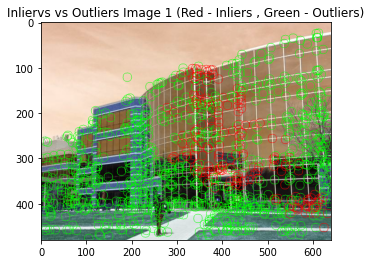

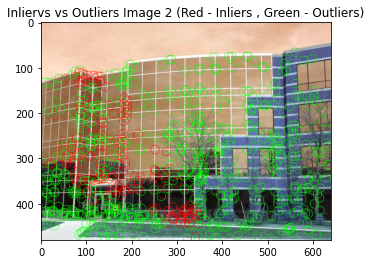

True

In [15]:
################### For image 1 , image 2 RANSAC INLIERS
image = image1.copy()
for i in range(len(good_match_image1_image2_1)) :
    if inliers_12[i] == True :
        center = (int(good_match_image1_image2_1[i][1]) , int(good_match_image1_image2_1[i][0]) )
        image = cv2.circle(image, center, 10, (255,0,0), 1)
    else :
        center = (int(good_match_image1_image2_1[i][1]) , int(good_match_image1_image2_1[i][0]) )
        image = cv2.circle(image, center, 10, (0,255,0), 1)
plt.imshow(image)
plt.title('Inliervs vs Outliers Image 1 (Red - Inliers , Green - Outliers)')
plt.show()
cv2.imwrite('Image1inliers_12.png' , image)

image = image2.copy()
for i in range(len(good_match_image1_image2_2)) :
    if inliers_12[i] == True :
        center = (int(good_match_image1_image2_2[i][1]) , int(good_match_image1_image2_2[i][0]) )
        image = cv2.circle(image, center, 10, (255,0,0), 1)
    else :
        center = (int(good_match_image1_image2_2[i][1]) , int(good_match_image1_image2_2[i][0]) )
        image = cv2.circle(image, center, 10, (0,255,0), 1)
plt.imshow(image)
plt.title('Inliervs vs Outliers Image 2 (Red - Inliers , Green - Outliers)')
plt.show()
cv2.imwrite('Image2Inliers_12.png' , image)

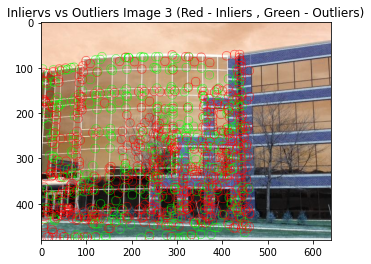

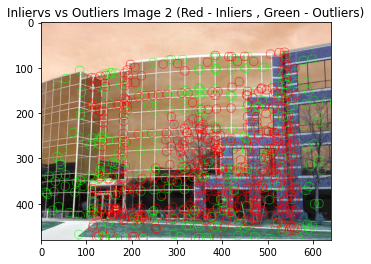

True

In [16]:
################### For image 1 , image 2 RANSAC INLIERS
image = image3.copy()
for i in range(len(good_match_image3_image2_3)) :
    if inliers_32[i] == True :
        center = (int(good_match_image3_image2_3[i][1]) , int(good_match_image3_image2_3[i][0]) )
        image = cv2.circle(image, center, 10, (255,0,0), 1)
    else :
        center = (int(good_match_image3_image2_3[i][1]) , int(good_match_image3_image2_3[i][0]) )
        image = cv2.circle(image, center, 10, (0,255,0), 1)
plt.imshow(image)
plt.title('Inliervs vs Outliers Image 3 (Red - Inliers , Green - Outliers)')
plt.show()
cv2.imwrite('Image1inliers_32.png' , image)

image = image2.copy()
for i in range(len(good_match_image3_image2_2)) :
    if inliers_32[i] == True :
        center = (int(good_match_image3_image2_2[i][1]) , int(good_match_image3_image2_2[i][0]) )
        image = cv2.circle(image, center, 10, (255,0,0), 1)
    else :
        center = (int(good_match_image3_image2_2[i][1]) , int(good_match_image3_image2_2[i][0]) )
        image = cv2.circle(image, center, 10, (0,255,0), 1)
plt.imshow(image)
plt.title('Inliervs vs Outliers Image 2 (Red - Inliers , Green - Outliers)')
plt.show()
cv2.imwrite('Image2Inliers_32.png' , image)